In [5]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from skmap.misc import find_files, GoogleSheet, ttprint
import warnings
import multiprocess as mp
import time
from scipy.special import expit, logit
import warnings
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, cross_val_score, HalvingGridSearchCV, KFold, GroupKFold, cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor 
import joblib
import pickle
from sklearn.metrics import r2_score, mean_squared_error, make_scorer#, root_mean_squared_error
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
# from cubist import Cubist
from sklearn.base import BaseEstimator, TransformerMixin
from pathlib import Path
from trees_rf import TreesRandomForestRegressor
from model_fit import read_features, cfi_calc, parameter_fine_tuning, calc_ccc, separate_texture_data, rscfi 
from model_fit import accuracy_plot, plot_top_features, pdp_hexbin, plot_histogram, calc_metrics, accuracy_strata_plot
import warnings
warnings.filterwarnings('ignore')
import os
from scipy.stats import boxcox
from scipy.special import inv_boxcox
import json
from datetime import datetime

folder_path = '/mnt/ripley/global_soc/scikit-map/global-soil-mapping'
version = '20250204'


# Separate Calibration (Cal), Train, and Test Data

Perform this separation **only once**, then save and read the separated data to ensure reproducibility.

#### Data ratio:
- **When data is limited**: Maintain the ratio between calibration, train, and test sets as `1:8:1`.
- **When data is abundant**: Allocate around **8,000 samples** for calibration and **6,000 samples** for testing.

#### How:
- **Strata with very few samples** (`count < 3`): Randomly assign samples to a set.
- **Strata with few samples** (`3 ≤ count < 10`): Distribute samples evenly across the sets.
- **Strata with sufficient samples** (`count ≥ 10`): Assign samples according to the specified ratio.


In [7]:
df = pd.read_parquet(f'{folder_path}/material/soil_pnts_organized_v{version}.pq')

cal_t1, cal_t2, train_t2, train_t2, test_t2, test_t2 = separate_texture_data('texture1', 'texture2', f'{folder_path}/textures', version, df, strata_col = ['hzn_dep_bin','clm_class'])

Size: Calibration 8004, Training 348600, Test 6006
Ratio: Calibration 0.02, Training 0.96, Test 0.02
Sum 362610, Dataframe size 362610


# Model calibration

In [3]:
with open(f'{folder_path}/material/soil_cov_no.bimonthly.landsat_v{version}.json', "r") as file:
    covar_cols = json.load(file)
print('total cov number: ', len(covar_cols))

for ii in range(0,len(prop_list)):
# for ii in [1]:
    
    prop = prop_list[ii]
    print(f'\n{prop}--------------------------------------------------------------')
    space = space_list[ii]
    output_folder = folder_path+'/'+prop
    os.makedirs(output_folder, exist_ok=True)
    
    if space=='log1p':
        # df.loc[:,f'{prop}_log1p'] = np.log1p(df[prop])
        tgt = f'{prop}_log1p'
    elif space=='boxcox':
        # df.loc[:,f'{prop}_log1p'] = np.log1p(df[prop])
        tgt = f'{prop}_boxcox'
        cal[f'{prop}_boxcox'], fitted_lambda = boxcox(cal['ocd'], lmbda=None)
    else:
        tgt = prop
    
    # read existing results
    cal = pd.read_parquet(f'{output_folder}/data_cal_{prop}_v{version}.pq')
    
    # # feature selection
    print('feature selection********************')
    cfi = cfi_calc(cal, tgt, prop, space, output_folder, version, covar_cols) # produce
    


total cov number:  327

bulk.density--------------------------------------------------------------
feature selection********************
start bootstrap on different subset...
[13:00:58] 0 iteration, training size: 5131
[13:01:44] 1 iteration, training size: 5131
[13:02:25] 2 iteration, training size: 5131
[13:03:05] 3 iteration, training size: 5131
[13:03:49] 4 iteration, training size: 5131
[13:04:30] 5 iteration, training size: 5131
[13:05:11] 6 iteration, training size: 5131
[13:05:52] 7 iteration, training size: 5131
[13:06:33] 8 iteration, training size: 5131
[13:07:17] 9 iteration, training size: 5131
[13:08:01] 10 iteration, training size: 5131
[13:08:40] 11 iteration, training size: 5131
[13:09:23] 12 iteration, training size: 5131
[13:10:01] 13 iteration, training size: 5131
[13:10:40] 14 iteration, training size: 5131
[13:11:22] 15 iteration, training size: 5131
[13:12:03] 16 iteration, training size: 5131
[13:12:49] 17 iteration, training size: 5131
[13:13:35] 18 iteration,

total cov number:  327

bulk.density--------------------------------------------------------------
[14:14:55] processing -0.0001194372257676 ...
[14:15:16] processing 0.0 ...
[14:15:32] processing 8.056277423240001e-05 ...
[14:15:50] processing 0.0002805627742324 ...
[14:15:59] processing 0.00048056277423240006 ...
[14:16:06] processing 0.0006805627742324 ...
[14:16:11] processing 0.0008805627742324001 ...
[14:16:14] processing 0.0010805627742324002 ...
[14:16:18] processing 0.0012805627742324 ...
[14:16:21] processing 0.0014805627742324001 ...
[14:16:23] processing 0.0016805627742324002 ...
[14:16:25] processing 0.0018805627742324 ...
[14:16:26] processing 0.0020805627742324 ...
[14:16:28] processing 0.0022805627742324003 ...
[14:16:30] processing 0.0024805627742324004 ...
[14:16:31] processing 0.0026805627742324 ...
[14:16:33] processing 0.0028805627742324 ...
[14:16:34] processing 0.0030805627742324 ...
[14:16:35] processing 0.0032805627742324003 ...
[14:16:36] processing 0.00568056

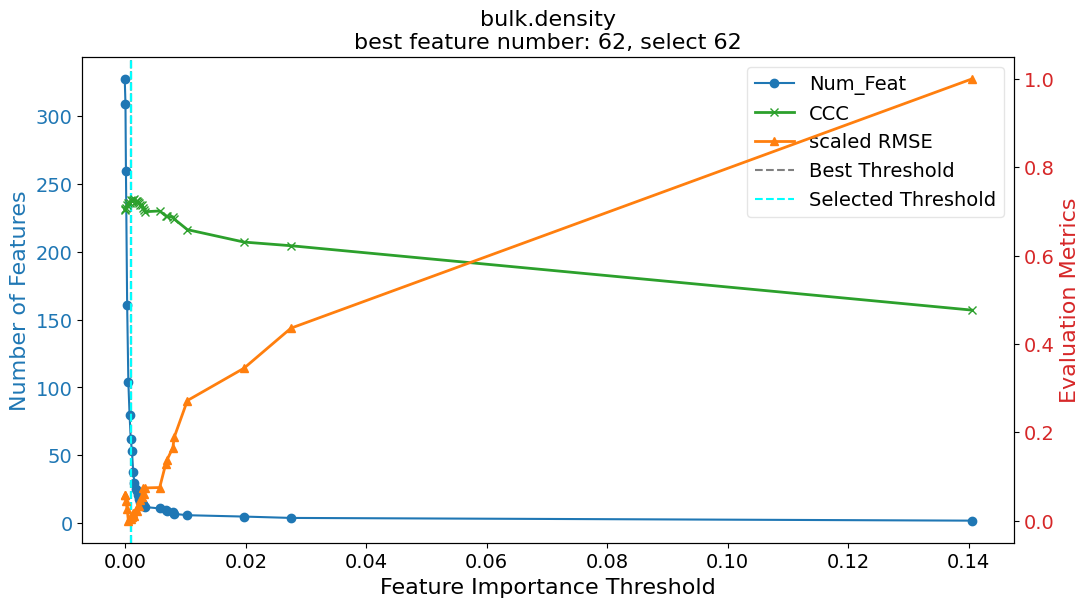

parameter fine tuning****************
[14:16:44] ----------------------rf------------------------
n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 96
max_resources_: 7798
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 135
n_resources: 96
Fitting 5 folds for each of 135 candidates, totalling 675 fits
----------
iter: 1
n_candidates: 45
n_resources: 288
Fitting 5 folds for each of 45 candidates, totalling 225 fits
----------
iter: 2
n_candidates: 15
n_resources: 864
Fitting 5 folds for each of 15 candidates, totalling 75 fits
----------
iter: 3
n_candidates: 5
n_resources: 2592
Fitting 5 folds for each of 5 candidates, totalling 25 fits
----------
iter: 4
n_candidates: 2
n_resources: 7776
Fitting 5 folds for each of 2 candidates, totalling 10 fits

ph.h2o--------------------------------------------------------------
[14:17:19] processing -0.0001410387674763 ...
[14:17:46] processing 0.0 ...
[14:18:01] processing 5.896123252370001

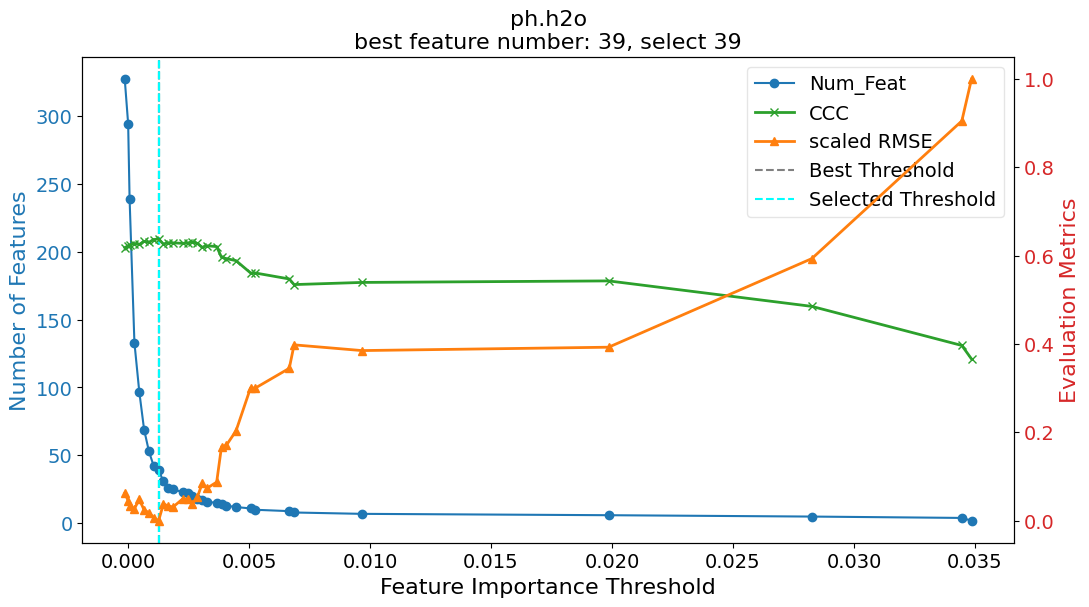

parameter fine tuning****************
[14:19:13] ----------------------rf------------------------
n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 97
max_resources_: 7864
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 135
n_resources: 97
Fitting 5 folds for each of 135 candidates, totalling 675 fits
----------
iter: 1
n_candidates: 45
n_resources: 291
Fitting 5 folds for each of 45 candidates, totalling 225 fits
----------
iter: 2
n_candidates: 15
n_resources: 873
Fitting 5 folds for each of 15 candidates, totalling 75 fits
----------
iter: 3
n_candidates: 5
n_resources: 2619
Fitting 5 folds for each of 5 candidates, totalling 25 fits
----------
iter: 4
n_candidates: 2
n_resources: 7857
Fitting 5 folds for each of 2 candidates, totalling 10 fits

texture1--------------------------------------------------------------
[14:19:50] processing -0.0002541397095158 ...
[14:20:36] processing -5.413970951580001e-05 ...
[14:21:09] process

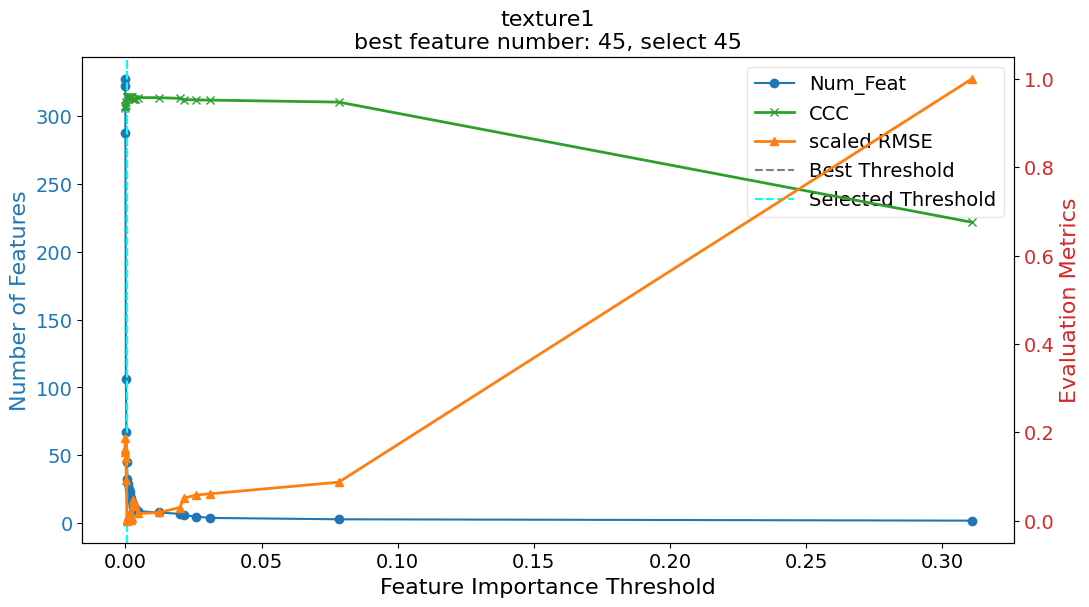

parameter fine tuning****************
[14:22:38] ----------------------rf------------------------
n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 97
max_resources_: 7872
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 135
n_resources: 97
Fitting 5 folds for each of 135 candidates, totalling 675 fits
----------
iter: 1
n_candidates: 45
n_resources: 291
Fitting 5 folds for each of 45 candidates, totalling 225 fits
----------
iter: 2
n_candidates: 15
n_resources: 873
Fitting 5 folds for each of 15 candidates, totalling 75 fits
----------
iter: 3
n_candidates: 5
n_resources: 2619
Fitting 5 folds for each of 5 candidates, totalling 25 fits
----------
iter: 4
n_candidates: 2
n_resources: 7857
Fitting 5 folds for each of 2 candidates, totalling 10 fits

texture2--------------------------------------------------------------
[14:23:08] processing -0.0611022269758082 ...
[14:23:45] processing -0.0609022269758082 ...
[14:24:09] processing

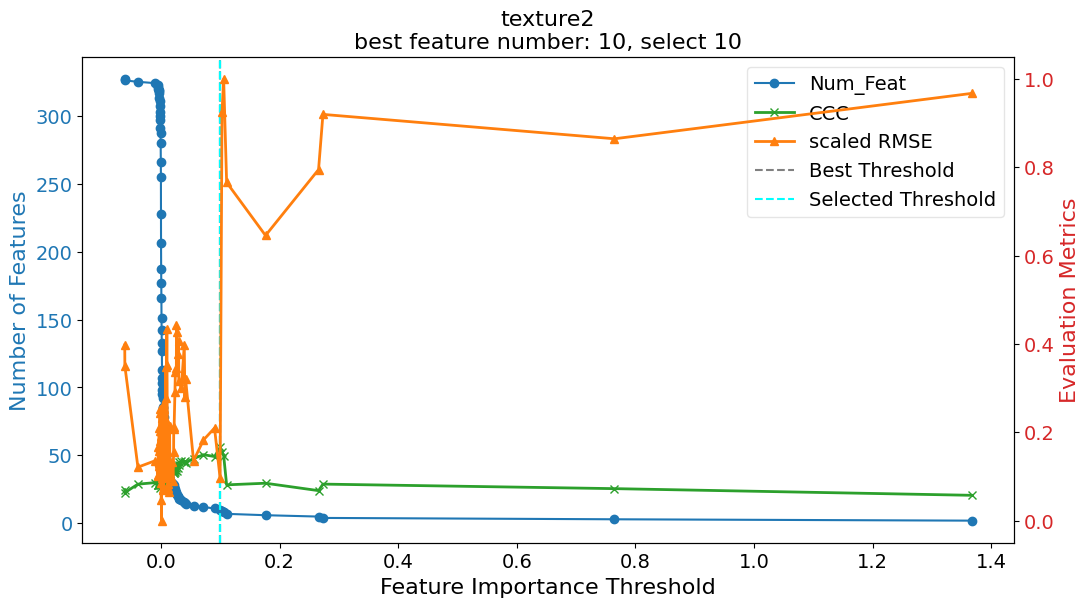

parameter fine tuning****************
[14:41:04] ----------------------rf------------------------
n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 94
max_resources_: 7634
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 135
n_resources: 94
Fitting 5 folds for each of 135 candidates, totalling 675 fits
----------
iter: 1
n_candidates: 45
n_resources: 282
Fitting 5 folds for each of 45 candidates, totalling 225 fits
----------
iter: 2
n_candidates: 15
n_resources: 846
Fitting 5 folds for each of 15 candidates, totalling 75 fits
----------
iter: 3
n_candidates: 5
n_resources: 2538
Fitting 5 folds for each of 5 candidates, totalling 25 fits
----------
iter: 4
n_candidates: 2
n_resources: 7614
Fitting 5 folds for each of 2 candidates, totalling 10 fits


In [4]:
with open(f'{folder_path}/material/soil_cov_no.bimonthly.landsat_v{version}.json', "r") as file:
    covar_cols = json.load(file)
print('total cov number: ', len(covar_cols))

min_convs_num = 60
for ii in range(0,len(prop_list)): 
    
    prop = prop_list[ii]
    print(f'\n{prop}--------------------------------------------------------------')
    space = space_list[ii]
    output_folder = folder_path+'/'+prop
    os.makedirs(output_folder, exist_ok=True)
    
    if space=='log1p':
        # df.loc[:,f'{prop}_log1p'] = np.log1p(df[prop])
        tgt = f'{prop}_log1p'
    elif space=='boxcox':
        # df.loc[:,f'{prop}_log1p'] = np.log1p(df[prop])
        tgt = f'{prop}_boxcox'
        cal[f'{prop}_boxcox'], fitted_lambda = boxcox(cal['ocd'], lmbda=None)
    else:
        tgt = prop
        
    cal = pd.read_parquet(f'{output_folder}/data_cal_{prop}_v{version}.pq')
    cfi = pd.read_csv(f'{output_folder}/feature_cfi_{prop}_v{version}.csv') # read in
    covs = rscfi(cal, tgt, prop, space, output_folder, version, covar_cols, cfi, min_convs_num, step_size=0.0002) # produce
         
    
    # ## read in existing results
    # covs = read_features(f'{output_folder}/feature_selected_{prop}_v{version}.txt') # read in
    ## parameter fine-tuning
    print('parameter fine tuning****************')
    models, model_names = parameter_fine_tuning(cal, covs, tgt, prop, output_folder, version)